In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib
import CombinedFC.CombinedFCToolBox as cfc
import ActflowToolbox as af
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import getTaskBetas
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Project directories
dataDir = '/projects/f_mc1689_1/AgingHubs/data'
scriptsDir = '/projects/f_mc1689_1/AgingHubs/docs/scripts'

# Subject numbers and basic info
subjectsFile = f'{scriptsDir}/subjects.tsv'
subjectsDF = pd.read_csv(subjectsFile,sep='\t',index_col='subjects')
subjGroup = subjectsDF['group'].values
subjList = subjectsDF.index.values
nSubjs = {'all':len(subjList), 'YA':len(subjList[subjGroup=='YA']), 'OA':len(subjList[subjGroup=='OA'])}

# fMRI run names
allRuns = ['rfMRI_REST1_AP','rfMRI_REST2_AP','rfMRI_REST1_PA','rfMRI_REST2_PA','tfMRI_VISMOTOR_PA','tfMRI_CARIT_PA','tfMRI_FACENAME_PA']
restRuns = ['rfMRI_REST1_AP','rfMRI_REST2_AP','rfMRI_REST1_PA','rfMRI_REST2_PA']

# Order of parcels by network
#parcType = 'cortex_subcortex'
parcType = 'cortex'
parcOrderFile = f'{scriptsDir}/cabnp/{parcType}_community_order.txt'
parcOrder = pd.read_csv(parcOrderFile, sep='\t', header=None)[0] - 1

if parcType == 'cortex_subcortex':
    nNodes = 718
elif parcType == 'cortex':
    nNodes = 360
nEdges = ((nNodes**2) - nNodes)//2

nodes = np.asarray(range(nNodes))

# More network info
netInfoFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt'
netInfo = pd.read_csv(netInfoFile, sep='\t')
print(netInfo)
netInfo = netInfo.iloc[parcOrder]
nodeNetKeys = netInfo['NETWORKKEY'].values - 1
nodeNets = netInfo['NETWORK'].values
networks = pd.unique(netInfo['NETWORK'])
nNets = len(networks)

netColors = np.empty((nNets,3))
for k,net in enumerate(networks):
    netColors[k,0] = netInfo.loc[netInfo['NETWORK'] == net, 'RED'].values[0]
    netColors[k,1] = netInfo.loc[netInfo['NETWORK'] == net, 'GREEN'].values[0]
    netColors[k,2] = netInfo.loc[netInfo['NETWORK'] == net, 'BLUE'].values[0]
    
nodeNetColors = np.empty((nNodes,3))
nodeNetColors[:,0] = netInfo['RED'].values
nodeNetColors[:,1] = netInfo['GREEN'].values
nodeNetColors[:,2] = netInfo['BLUE'].values

# Vertex assignments
#vertexFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_netassignments_LR.dscalar.nii'
vertexFile = f'{scriptsDir}/cabnp/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dscalar.nii'

vertexLabels = np.squeeze(nib.load(vertexFile).get_fdata())

def loadVertexParcelActivations(data,parcel,vlabels=vertexLabels):
    idx = np.where(vlabels==parcel)[0]
    data = np.array((data))
    return data[:,idx]
    
print('Subjects:\t',nSubjs)
print('Nodes:\t\t',nNodes)

     INDEX  KEYVALUE                           LABEL    RED  GREEN  BLUE  \
0        1         1                Visual1-04_L-Ctx  0.000   0.00   1.0   
1        2         2                Visual2-28_L-Ctx  0.392   0.00   1.0   
2        3         3                Visual2-29_L-Ctx  0.392   0.00   1.0   
3        4         4                Visual2-30_L-Ctx  0.392   0.00   1.0   
4        5         5                Visual2-31_L-Ctx  0.392   0.00   1.0   
..     ...       ...                             ...    ...    ...   ...   
713    714     12130  Orbito-Affective-13_R-Pallidum  0.255   0.49   0.0   
714    715     12140   Orbito-Affective-14_L-Putamen  0.255   0.49   0.0   
715    716     12150   Orbito-Affective-15_L-Putamen  0.255   0.49   0.0   
716    717     12160   Orbito-Affective-16_R-Putamen  0.255   0.49   0.0   
717    718     12170   Orbito-Affective-17_R-Putamen  0.255   0.49   0.0   

     ALPHA HEMISPHERE           NETWORK  NETWORKKEY  NETWORKSORTEDORDER  
0    1.000   

In [ ]:
print(vertexLabels.shape)
print(vertexLabels)
print(max(vertexLabels))

In [2]:
faceLabels = np.full((40),'OO')
for b in range(0,40,10):
    faceLabels[0+b] = 'M1'
    faceLabels[1+b] = 'M2'
    faceLabels[2+b] = 'M3'
    faceLabels[3+b] = 'M4'
    faceLabels[4+b] = 'M5'
    faceLabels[5+b] = 'F1'
    faceLabels[6+b] = 'F2'
    faceLabels[7+b] = 'F3'
    faceLabels[8+b] = 'F4'
    faceLabels[9+b] = 'F5'
    
print(faceLabels)  

trainSet = np.full((40,4),True)
trainSet[0:10,0] = False
trainSet[10:20,1] = False
trainSet[20:30,2] = False
trainSet[30:40,3] = False

testSet = np.full((40,4),False)
testSet[0:10,0] = True
testSet[10:20,1] = True
testSet[20:30,2] = True
testSet[30:40,3] = True

#print(trainSet,testSet)

['M1' 'M2' 'M3' 'M4' 'M5' 'F1' 'F2' 'F3' 'F4' 'F5' 'M1' 'M2' 'M3' 'M4'
 'M5' 'F1' 'F2' 'F3' 'F4' 'F5' 'M1' 'M2' 'M3' 'M4' 'M5' 'F1' 'F2' 'F3'
 'F4' 'F5' 'M1' 'M2' 'M3' 'M4' 'M5' 'F1' 'F2' 'F3' 'F4' 'F5']


In [3]:
parcFeatures = np.zeros((nNodes))
data = getTaskBetas.runSubj(subjList[0],'tfMRI_FACENAME_PA/vertices/canonicalHRF').T
for p in range(nNodes):
    parcData = loadVertexParcelActivations(data,p+1)
    parcFeatures[p] = parcData.shape[1]

In [2]:
#classAcc = np.full((nNodes,nSubjs['all']),np.nan)

#for s,subj in enumerate(subjList):
    #data = getTaskBetas.runSubj(subj,'tfMRI_FACENAME_PA/vertices/canonicalHRF').T
    #print(data.shape)
    
    #sc = StandardScaler()
    #data_scaled = sc.fit_transform(data)
    
    #for p in range(nNodes):
        #print()
        #parcData_scaled = loadVertexParcelActivations(data_scaled,p+1)
        #parcFeatures[p] = parcData_scaled.shape[1]
        #print(parcData_scaled.shape)
        #print(parcData)
        
        #scores = np.zeros((4))
        #for fold in range(4):
            #svm = SVC(C=100).fit(parcData_scaled[trainSet[:,fold]],faceLabels[trainSet[:,fold]])
            #scores[fold] = svm.score(parcData_scaled[testSet[:,fold]],faceLabels[testSet[:,fold]])
            
            #neighbors = KNeighborsClassifier(n_neighbors=6).fit(parcData_scaled[trainSet[:,fold]],faceLabels[trainSet[:,fold]])
            #scores[fold] = neighbors.score(parcData_scaled[testSet[:,fold]],faceLabels[testSet[:,fold]])
            
            #bayes = GaussianNB().fit(parcData_scaled[trainSet[:,fold]],faceLabels[trainSet[:,fold]])
            #scores[fold] = bayes.score(parcData_scaled[testSet[:,fold]],faceLabels[testSet[:,fold]])
            
            #qda = QuadraticDiscriminantAnalysis().fit(parcData_scaled[trainSet[:,fold]],faceLabels[trainSet[:,fold]])
            #scores[fold] = qda.score(parcData_scaled[testSet[:,fold]],faceLabels[testSet[:,fold]])
            
        #classAcc[p,s] = np.mean(scores)
    
    #subjFile = f'{dataDir}/faces/classificationAccuracy_qda/{subj}.npy'
    #np.save(subjFile,classAcc[:,s])
    
#outFile = f'{dataDir}/faces/classificationAccuracy_qda.npy'
#np.save(outFile,classAcc)

Text(0.5, 0, 'Classification Method')

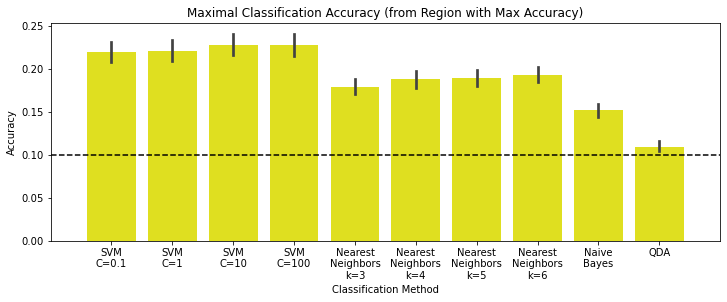

In [4]:
classMethods = ['svm_C-0.1','svm_C-1','svm_C-10','svm_C-100','nearestNeighbors_k-3','nearestNeighbors_k-4','nearestNeighbors_k-5','nearestNeighbors_k-6','naiveBayes','qda']
maxAcc = np.zeros((len(classMethods),268))

for m,method in enumerate(classMethods):
    outFile = f'{dataDir}/faces/classificationAccuracy_{method}.npy'
    classAcc = np.load(outFile)
    meanClassAcc = np.nanmean(classAcc,axis=1)
    #maxAcc[m,:] = classAcc[183,:]
    maxAcc[m,:] = classAcc[meanClassAcc==np.amax(meanClassAcc),:]

plt.figure(figsize=(12,4))
#plt.bar(np.asarray(range(1,m+2)),maxAcc,tick_label=['C=0.1','C=1','C=10','C=100','k=3','k=4','k=5','k=6'])
#plt.plot([0,9],[.1,.1],'r')
#plt.xlim([0,9])
sns.barplot(data=maxAcc.T,color='yellow')
plt.xticks(ticks=np.asarray(range(m+1)),labels=['SVM\nC=0.1','SVM\nC=1','SVM\nC=10','SVM\nC=100','Nearest\nNeighbors\nk=3','Nearest\nNeighbors\nk=4','Nearest\nNeighbors\nk=5','Nearest\nNeighbors\nk=6','Naive\nBayes','QDA'])
plt.title('Maximal Classification Accuracy (from Region with Max Accuracy)')
plt.plot([-1,10],[.1,.1],'--k')
plt.xlim([-1,10])
plt.ylabel('Accuracy')
plt.xlabel('Classification Method')


In [2]:
outFile = f'{dataDir}/faces/classificationAccuracy_svm_C-10.npy'
#outFile = f'{dataDir}/faces/classificationAccuracy_naiveBayes.npy'
classAcc = np.load(outFile)
meanClassAcc = np.nanmean(classAcc,axis=1)

print(meanClassAcc[197]) # Right FFA
print(meanClassAcc[17]) # Left FFA

0.14216417910447762
0.14664179104477615


In [3]:
# Significant classification accuracy - all subjects
Tstats = np.zeros((nNodes))
pvals = np.zeros((nNodes))

for p in range(nNodes):
    Tstats[p],pvals[p] = stats.ttest_1samp(classAcc[p,:],0.1,alternative='greater')

sig = pvals<(.05/nNodes)
sigNodes = nodes[sig]
#print(sigNodes)
#print(pvals[197],pvals[17])

pvals_FDRcorrected = sm.stats.multipletests(pvals,method='fdr_bh')
sig = pvals_FDRcorrected[0]
sigNodes = nodes[sig]
print(sigNodes)
print(meanClassAcc[sig])

[  0   1   2   3   4   5   6   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  24  25  27  28  29  33  34  37  44  45  47  49  50  53  55
  62  65  66  69  72  73  74  77  78  79  80  81  82  83  84  85  86  90
  94  96 104 115 116 127 128 132 135 136 137 138 139 140 141 142 143 144
 145 147 148 149 150 151 152 153 155 156 157 158 162 175 180 181 182 183
 184 185 186 189 190 191 192 194 195 196 197 198 199 200 201 202 204 206
 207 208 209 210 211 214 217 222 226 227 229 242 246 252 253 254 256 257
 258 260 265 274 276 290 296 300 307 308 309 312 316 317 318 319 320 321
 322 323 324 325 328 329 330 331 332 333 335 336 337 338 339 340 342 348
 355]
[0.21529851 0.10839552 0.12005597 0.22416045 0.20149254 0.18171642
 0.13554104 0.10858209 0.11809701 0.10839552 0.12705224 0.14402985
 0.11716418 0.10904851 0.11893657 0.14664179 0.12425373 0.11697761
 0.12882463 0.14720149 0.1136194  0.11595149 0.10830224 0.11436567
 0.11324627 0.11212687 0.10914179 0.11016791 0.10942164 0.10998134
 0

(0.0, 94.0)

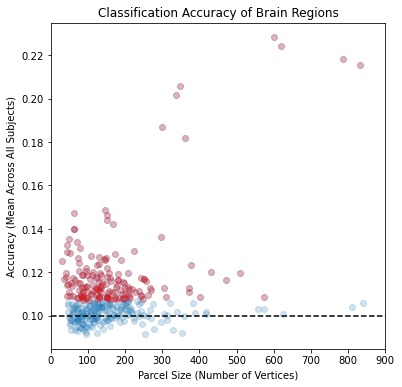

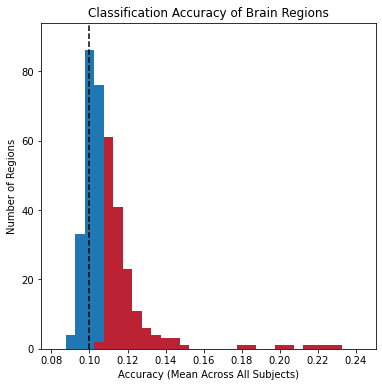

In [7]:
plt.figure(figsize=(6,6))
plt.plot([0,900],[.1,.1],'--k')
plt.scatter(parcFeatures,meanClassAcc,alpha=.2)
plt.scatter(parcFeatures[sig],meanClassAcc[sig],color='r',alpha=.2)
plt.title('Classification Accuracy of Brain Regions')
plt.xlabel('Parcel Size (Number of Vertices)')
plt.ylabel('Accuracy (Mean Across All Subjects)')
plt.xlim(0,900)

plt.figure(figsize=(6,6))
plt.hist(meanClassAcc,bins=32,range=[.0825,.2425])
plt.hist(meanClassAcc[sig],bins=32,range=[.0825,.2425],color='r',alpha=.7)
plt.plot([.1,.1],[0,94],'--k')
plt.title('Classification Accuracy of Brain Regions')
plt.xlabel('Accuracy (Mean Across All Subjects)')
plt.ylabel('Number of Regions')
plt.ylim(0,94)




Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii was 0.154255 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.088133 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii was 0.156058 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.L.very_inflated_MSMAll.32k_fs_LR.surf.gii was 0.085697 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii was 0.119124 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii was 0.153526 seconds.


Info: Time to read /projectsn/f_mc1689_1/AnalysisTools/ColeAnticevicNetPartition/S1200.R.pial_MSMAll

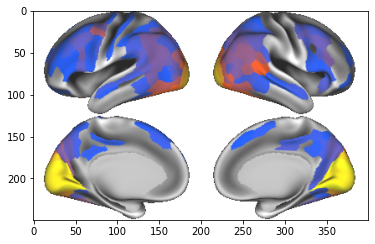

In [8]:
import matplotlib.image as mpimg
from utils.get_network_info import get_network_info
from utils.print_wb_scene import print_wb_scene
from utils.mapToSurface import map_to_surface
from utils.remove_border import remove_border

plotMeanClassAcc = np.full((nNodes),np.nan)
plotMeanClassAcc[sig] = meanClassAcc[sig]

map_to_surface(plotMeanClassAcc,'meanClassificationAccuracy',fliphemispheres=False)
filename = '/projects/f_mc1689_1/AgingHubs/docs/scripts/meanClassificationAccuracy.dscalar.nii'
print_wb_scene(filename,'meanClassificationAccuracy',inflation='inflated')
img = mpimg.imread('meanClassificationAccuracy.png')
imgPlot = plt.imshow(img)


In [4]:
Tstats_groupDiff = np.full((nNodes),np.nan)
pvals_groupDiff = np.full((nNodes),np.nan)

#for p in nodes[meanClassAcc>=.12]:
for p in nodes:
    Tstats_groupDiff[p],pvals_groupDiff[p] = stats.ttest_ind(classAcc[p,subjGroup=='YA'],classAcc[p,subjGroup=='OA'])
    #print(p,np.mean(classAcc[p,subjGroup=='YA']),np.mean(classAcc[p,subjGroup=='OA']),Tstats_groupDiff[p],pvals_groupDiff[p])

#pvals_FDRcorrected = sm.stats.multipletests(pvals_groupDiff,method='fdr_bh')
#sig_groupDiff = pvals_FDRcorrected[0]
#sigNodes_groupDiff = nodes[sig_groupDiff]
#print(sigNodes_groupDiff) 


Text(0.5, 1.0, 'Classification Accuracy in Younger vs Older Adults')

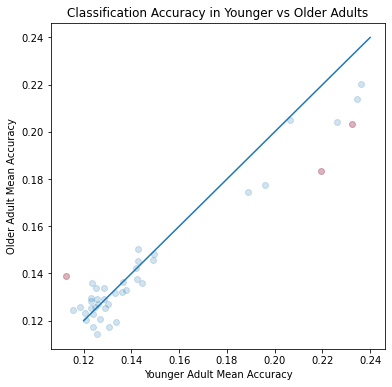

In [5]:
meanClassAcc_YA = np.mean(classAcc[:,subjGroup=='YA'],axis=1)
meanClassAcc_OA = np.mean(classAcc[:,subjGroup=='OA'],axis=1)


plt.figure(figsize=(6,6))
plt.scatter(meanClassAcc_YA[meanClassAcc>=.12],meanClassAcc_OA[meanClassAcc>=.12],alpha=.2)
plt.scatter(meanClassAcc_YA[(meanClassAcc>=.12)&(pvals_groupDiff<=.05)],meanClassAcc_OA[(meanClassAcc>=.12)&(pvals_groupDiff<=.05)],alpha=.2,color='r')
plt.plot([.12,.24],[.12,.24])
plt.xlabel('Younger Adult Mean Accuracy')
plt.ylabel('Older Adult Mean Accuracy')
plt.title('Classification Accuracy in Younger vs Older Adults')


In [9]:
maxNodes = nodes[meanClassAcc > .1399]
print(len(maxNodes))
print(maxNodes+1)
print(meanClassAcc_YA[maxNodes])

15
[  1   4   5   6  13  18  22 181 184 185 186 187 193 198 202]
[0.22630597 0.23432836 0.21940299 0.18880597 0.14291045 0.14272388
 0.1488806  0.23246269 0.23600746 0.20652985 0.19608209 0.14440299
 0.14962687 0.14197761 0.14216418]


Text(0.5, 1.0, 'Structural Connectivity')

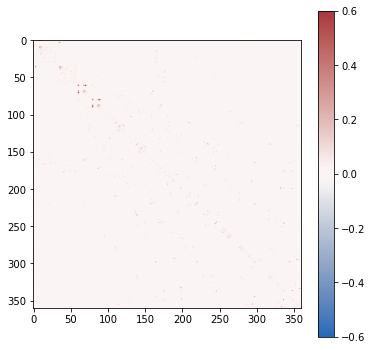

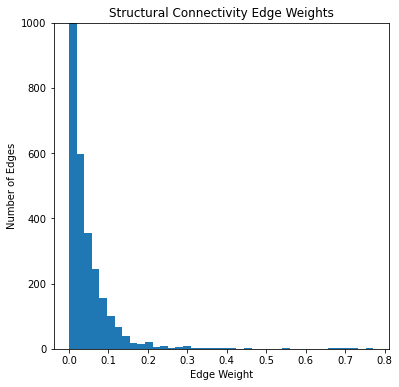

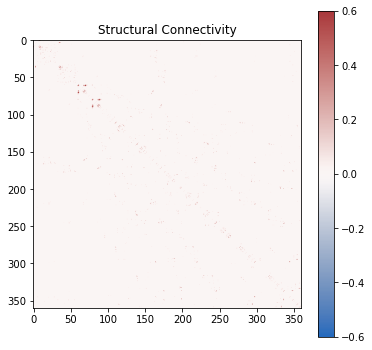

In [6]:
struct = np.load(f'{dataDir}/results/connectivity/structural_cortex.npy')
#print(struct[:,:,0])
pvals_struct = np.full((nNodes,nNodes),np.nan)
Tstats_struct = np.full((nNodes,nNodes),np.nan)
for n1 in range(nNodes):
    for n2 in range(n1,nNodes): 
        Tstats_struct[n1,n2],pvals_struct[n1,n2] = stats.ttest_1samp(struct[n1,n2,:],0,nan_policy='omit')
        pvals_struct[n2,n1] = pvals_struct[n1,n2]
        Tstats_struct[n2,n1] = Tstats_struct[n1,n2]

#pvals_FDRcorrected = sm.stats.multipletests(pvals_struct,method='fdr_bh')
#sig_struct = pvals_FDRcorrected[0]
sig_struct = pvals_struct <= (.05/nEdges)
#print(sig_struct)
 
avgStruct = np.nanmean(struct,axis=2)
avgStruct_thresh = np.zeros((nNodes,nNodes))
avgStruct_thresh[sig_struct] = avgStruct[sig_struct]
plt.figure(figsize=(6,6))
plt.imshow(avgStruct_thresh,cmap='vlag',vmin=-.6,vmax=.6)    
plt.colorbar()
    
#print(np.amax(avgStruct))

plt.figure(figsize=(6,6))
plt.hist(avgStruct_thresh[np.triu_indices(nNodes, k = 1)],bins=40)
plt.ylim(0,1000)
plt.title('Structural Connectivity Edge Weights')
plt.xlabel('Edge Weight')
plt.ylabel('Number of Edges')

avgStruct_thresh[avgStruct_thresh<.05] = 0
plt.figure(figsize=(6,6))
plt.imshow(avgStruct_thresh,cmap='vlag',vmin=-.6,vmax=.6)    
plt.colorbar()
plt.title('Structural Connectivity')


In [13]:
adjacent = np.full((nNodes),False)

for n in maxNodes:
    adj = (avgStruct_thresh[n,:] > 0) & (~(meanClassAcc > .1399))
    
    print(n)
    print(nodes[adj])
    print(pvals_groupDiff[adj],Tstats_groupDiff[adj])
    print()
    adjacent = adjacent | adj
    
print(nodes[adjacent])

0
[ 7  8  9 10]
[0.94194618 0.06202272 0.42784522 0.0289955 ] [ 0.07289283 -1.87402787 -0.79409976  2.1954468 ]

3
[34 35 36 37]
[0.4684549  0.09103352 0.15982247 0.7091827 ] [-0.72603623  1.6961178  -1.40961163 -0.37335354]

4
[]
[] []

5
[ 34  51 224]
[0.4684549  0.79715186 0.55477469] [-0.72603623  0.25729255 -0.59137009]

12
[ 8  9 10 13 16 24]
[0.06202272 0.42784522 0.0289955  0.89037892 0.94362812 0.28828283] [-1.87402787 -0.79409976  2.1954468  -0.13795681  0.07077738  1.06402387]

17
[10 29 30]
[0.0289955  0.03460208 0.02340685] [ 2.1954468  -2.12389129 -2.27987719]

21
[ 22  67 157 158 161 218 219 220 298]
[0.73805448 0.38091696 0.63589461 0.12360966 0.19298616 0.66029022
 0.23995955 0.24142559 0.73965559] [-0.33478054  0.87766611  0.47399176 -1.54469186  1.30510136 -0.44000579
 -1.17772331 -1.17404868  0.33265652]

180
[102 103 109 131 132 182 193 204 228 280]
[0.12693701 0.91494988 0.38343295 0.03961723 0.87598694 0.46613645
 0.58263743 0.50134207 0.88783129 0.51404764] [-1.

Text(0.5, 1.0, 'Classification Accuracy in Younger vs Older Adults')

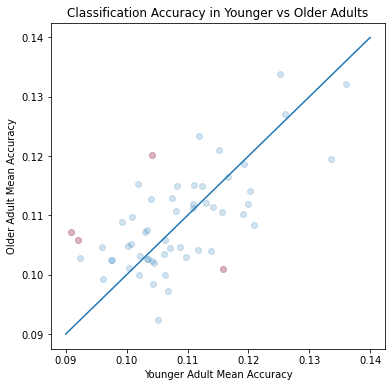

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(meanClassAcc_YA[adjacent],meanClassAcc_OA[adjacent],alpha=.2)
plt.scatter(meanClassAcc_YA[(adjacent)&(pvals_groupDiff<=.05)],meanClassAcc_OA[(adjacent)&(pvals_groupDiff<=.05)],alpha=.2,color='r')
plt.plot([.09,.14],[.09,.14])
plt.xlabel('Younger Adult Mean Accuracy')
plt.ylabel('Older Adult Mean Accuracy')
plt.title('Classification Accuracy in Younger vs Older Adults')

In [20]:
print(nNodes)
print(len(nodes[(pvals_groupDiff<=.05)]))
print(len(nodes[(pvals_groupDiff<=.05) & (meanClassAcc_YA>meanClassAcc_OA)]))
print()
print(len(nodes[adjacent]))
print(len(nodes[(pvals_groupDiff<=.05) & adjacent]))
print(len(nodes[(pvals_groupDiff<=.05) & (meanClassAcc_YA>meanClassAcc_OA) & adjacent]))
print()
print(len(nodes[meanClassAcc > .1399]))
print(len(nodes[(pvals_groupDiff<=.05) & (meanClassAcc > .1399)]))
print(len(nodes[(pvals_groupDiff<=.05) & (meanClassAcc_YA>meanClassAcc_OA) & (meanClassAcc > .1399)]))


360
20
5

57
4
1

15
2
2
